In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.family"] = "Sathu"

## Parameters

In [2]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1626_BmTreg_HTO"
workflow_id = "36f39f48-0503-4ab7-b8db-f2fd35a7f4fd"
path_data = os.path.join("./data/", sample_name, workflow_id)

## Run Report

In [3]:
!cat $path_data/report/run_report.yaml

Date: 2019-12-09
Running time: 26.0 minutes, 43.34 seconds
CITE-seq-Count Version: 1.4.3
Reads processed: 58448423
Percentage mapped: 96
Percentage unmapped: 4
Uncorrected cells: 157
Correction:
	Cell barcodes collapsing threshold: 1
	Cell barcodes corrected: 113533
	UMI collapsing threshold: 1
	UMIs corrected: 147958
Run parameters:
	Read1_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/36f39f48-0503-4ab7-b8db-f2fd35a7f4fd/call-TrimR1/R1.fastq.gz
	Read2_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/36f39f48-0503-4ab7-b8db-f2fd35a7f4fd/call-TrimR2/R2.fastq.gz
	Cell barcode:
		First position: 1
		Last position: 16
	UMI barcode:
		First position: 17
		Last position: 28
	Expected cells: 0
	Tags max errors: 2
	Start trim: 0


## Classification

### Read

In [4]:
df_class = pd.read_csv(
    os.path.join(path_data, "final-classification.tsv.gz"),
    sep="\t",
    compression="gzip",
    index_col=0
)

In [5]:
df_class

,hashID
120703409057195,A0302
120703409315118,A0304
120703409575651,A0303
120703409666781,A0301
120703423999332,A0304
120703424056627,Doublet
120703436377397,A0301
120703436668253,A0303
120703436934446,A0301
120703455444197,A0302


In [6]:
df_class.shape

(9606, 1)

### Numeric to ACGT

In [7]:
from dna3bit import DNA3Bit

In [8]:
dna3bit = DNA3Bit()

In [9]:
new_index = df_class.index.map(lambda x: dna3bit.decode(x).decode())

In [10]:
df_class.index = new_index

In [11]:
df_class

,hashID
TTTATGCTCATCCCGT,A0302
TTTATGCTCGTGCAGC,A0304
TTTATGCTCCTGTTAT,A0303
TTTATGCTCCCTGTTG,A0301
TTTATGCAGGTCCGAA,A0304
TTTATGCAGGGACACT,Doublet
TTTATGCGTAGACACG,A0301
TTTATGCGTGCTCGTG,A0303
TTTATGCGTCCACAGC,A0301
TTTATGCCAGTTCTAG,A0302


### Results

In [12]:
df_stats = df_class.groupby(by="hashID").size()
df_stats

hashID
A0301      2402
A0302      1474
A0303      2236
A0304      2586
Doublet     908
dtype: int64

In [13]:
df_stats.sum()

9606

### Pie Chart

In [14]:
labels = [label.upper() if label != "Doublet" else "Doublet/Negative" for label in df_stats.index]
labels

['A0301', 'A0302', 'A0303', 'A0304', 'Doublet/Negative']

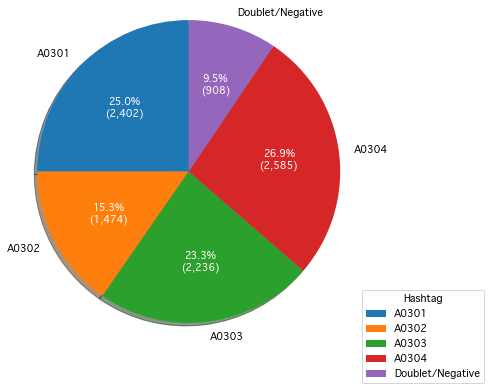

In [15]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

wedges, _, autotexts = ax.pie(
    df_stats,
    labels=labels,
    autopct=lambda pct: func_autopct(pct, df_stats),    
    shadow=True, startangle=90
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    loc="center left",
    bbox_to_anchor=(1, -0.5, 0.5, 1)
)

plt.show()

### Distribution

In [16]:
df_dist = df_stats.drop(labels=["Doublet"])
df_dist

hashID
A0301    2402
A0302    1474
A0303    2236
A0304    2586
dtype: int64

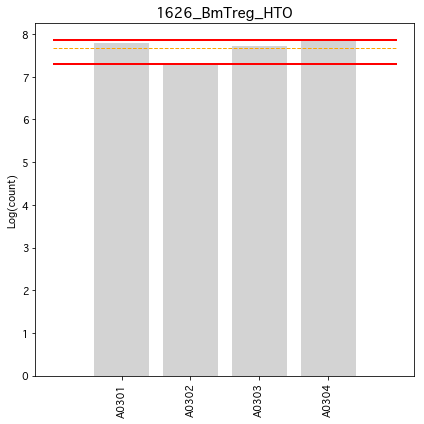

In [17]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.bar(df_dist.index, np.log(list(df_dist.values)), color="lightgray")
    
ax.set_ylabel("Log(count)", fontweight="bold")
ax.set_title(sample_name, fontsize=14, fontweight="heavy")
ax.tick_params(axis="x", rotation=90)
    
num_hashtags = len(df_dist.values)
ax.hlines(y=np.log(max(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
ax.hlines(y=np.log(min(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)    
ax.hlines(y=np.log(np.mean(list(df_dist.values))), xmin=-1, xmax=num_hashtags, colors='orange', linestyles='--', lw=1)    

plt.tight_layout()

plt.show()

## Reads Count

In [18]:
import numpy as np
import scipy.io

In [19]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "reads/matrix.mtx.gz")
)

In [20]:
barcodes = pd.read_csv(
    os.path.join(path_data, "reads/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [21]:
features = pd.read_csv(
    os.path.join(path_data, "reads/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [22]:
df_reads = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [23]:
df_reads

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
ATCACTTAGTGAACAT,721,25,33,7,65
CTCCAACGTGGTCCCA,19,14,39,696,12
ACAGGGACAGTCGTTA,14,11,36,506,17
AGCGTCGTCCCATTTA,154,9,6,1,11
ATGGAGGGTACTCCGG,594,38,37,9,50
TATCTTGGTATGAAGT,15,3,0,111,0
TCATCATAGCCGATCC,24,744,52,35,35
CACGGGTCATGTTCGA,49,79,23,799,15
CCCATTGGTCAGCTTA,27,22,48,441,23


### Total Counts per Hashtag

In [24]:
df_reads.sum()

0
A0301-ACCCACCAGTAAGAC    2939722
A0302-GGTCGAGAGCATTCA    6645954
A0303-CTTGCCGCATGTCAT    3731985
A0304-AAAGCATTCTTCACG    2611315
unmapped                  662925
dtype: int64

### Total Counts per Celluar Barcode

In [25]:
df_reads.sum(axis=1)

0
ATCACTTAGTGAACAT      851
CTCCAACGTGGTCCCA      780
ACAGGGACAGTCGTTA      584
AGCGTCGTCCCATTTA      181
ATGGAGGGTACTCCGG      728
TATCTTGGTATGAAGT      129
TCATCATAGCCGATCC      890
CACGGGTCATGTTCGA      965
CCCATTGGTCAGCTTA      561
TGCTTGCGTGCTAGCC     1008
ATCGTCCAGGTTCCAT      655
CCTATCGCATCCTATT      570
GGAGATGTCGATAACC      694
TATGTTCGTCCAACGC      675
TCCATCGGTATACCTG      777
TCACTCGGTGGCTCTG     2633
GATCATGTCATTCGTT      221
GTGGCGTCAAATTAGG      688
AGCTACAGTCGAATTC    19030
AACCTGAGTACCTGTA      530
ATGTCCCTCTAGGAAA      603
GATGACTAGTCATAGA      761
CACCAAAGTATGTGTC      734
CTGAGGCCAAGTCGTT     1824
CCATCACTCTAATTCC      830
AATTCCTTCGCCACTT     1665
TTACGTTAGTGAGTGC      862
TACCTCGTCCGCGAGT     1271
TCTCAGCCATTGAGCT      671
TATCTTGGTAGCTGAG     1671
                    ...  
GTTGAACAGCATTGAA      644
GACTCTCTCCGGTTCT     2390
TAACACGGTCCAAGAG      817
CTTCCTTGTATCGAGG      580
GAGAGGTTCGGCATAT      974
GTAGCTATCGAGCTGC      662
GCTACCTAGCACACAG      606
TTGAACGTCA

### First Hashtag

In [26]:
# remove "Doublet" and pick the first hashtag
hashtags = list(set(df_class.hashID.unique()) - set(["Doublet"]))
first_hashtag = hashtags[0] if len(hashtags) > 0 else None
first_hashtag

'A0301'

In [27]:
df_reads.loc[ df_class[ df_class.hashID == first_hashtag ].index ].sort_values(by=df_reads.columns[0], ascending=False)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
ATCGTGACACCTGCGA,52423,43,53,33,2760
TCGTCCAAGCTAAACA,32960,27,39,948,2109
GTCATGAGTGTAAATG,29492,34,36,30,1738
CAACAGTGTGTCCACG,28719,36,54,46,1900
TGTTGGACAATTCTTC,26692,48,64,27,1659
ACTTTGTAGACTAGAT,23885,43,30,20,1458
TGAGCGCAGATGAACT,23817,40,68,557,1477
CTTCTCTGTCTTTATC,23244,16,31,43,1505
CAATTTCAGTTAACGA,21493,24,613,24,1448
GTAGCTAAGGTAGTAT,20761,642,631,194,1478


### Overall Stats

In [28]:
df_reads.sum(axis=1).sort_values(ascending=False).describe()

count      9606.000000
mean       1727.243494
std        7780.137231
min           0.000000
25%         663.000000
50%         827.000000
75%        1154.000000
max      481551.000000
dtype: float64

### 95 Percentile

In [29]:
percentile_95 = df_reads.sum(axis=1).describe(percentiles=[0.95])["95%"]
percentile_95

4495.0

In [30]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
AGCTACAGTCGAATTC,72,17943,37,18,960
AAGTACCAGTCGCTAT,60,37,13587,600,583
TTCCGTGGTGAGGCAT,26,69,39,7706,142
CATCGTCGTAGTATAG,3422,161,4486,1211,317
CTTCTCTGTCTTTATC,23244,16,31,43,1505
ATCGGCGAGTAATTGG,110,32951,18,31,1012
ACACCAACACGTACTA,78,173,58,46197,1091
AAGTACCAGAATCGAT,38,7310,63,66,376
GGAAGTGTCACCATAG,36,8076,27,17,255


In [31]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
GCGAGAATCCCGAGGT,22,89,27397,164,795
CAGCAATAGGTTCTAC,104,23105,681,25,800
TTGTTGTCAGAACTCT,90,21981,29,18,562
GTCATGAGTCCAGAAG,39,71,23302,68,739
GTTACCCCACAAAGCG,16,44,36,7655,183


In [32]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0).sum(axis=1)

0
GCGAGAATCCCGAGGT    28467
CAGCAATAGGTTCTAC    24715
TTGTTGTCAGAACTCT    22680
GTCATGAGTCCAGAAG    24219
GTTACCCCACAAAGCG     7934
dtype: int64

### Histogram (sum of reads across hashtags)

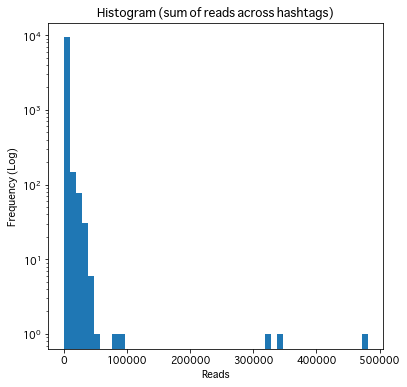

In [33]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.hist(df_reads.sum(axis=1).sort_values(ascending=False), bins=50)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.set_title("Histogram (sum of reads across hashtags)", fontweight="bold")

plt.yscale("log")
plt.show()

### Histogram (sum of reads per hashtag)

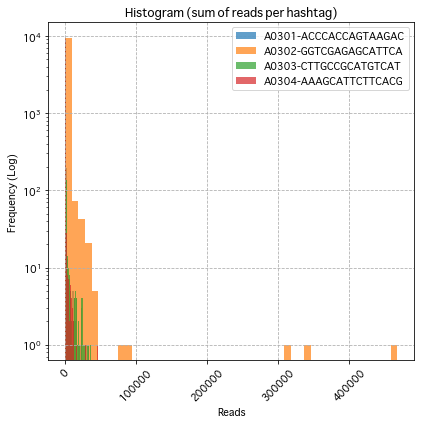

In [34]:
fig = plt.figure(figsize=(6, 6), facecolor="white")

ax = fig.add_subplot(111)
    
for idx, col in enumerate(df_reads.columns[:-1]):
    
    df_tmp = df_reads.iloc[:,idx].sort_values(ascending=False)

    ax.hist(df_tmp, bins=50, alpha=0.7)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Histogram (sum of reads per hashtag)", fontweight="bold")
ax.grid(b=True, linestyle="--")
ax.legend()

plt.yscale("log")
plt.tight_layout()
plt.show()

### Unmapped

In [35]:
df_reads.sort_values(by="unmapped", ascending=False).iloc[:,-1]

0
CATCAAGCACCAATTG    11386
GAGGGATTCATTGCCC     6767
GTGAGTTGTGGAAGTC     6143
GGAACCCTCTCCTGAC     3135
ATCGTGACACCTGCGA     2760
AGTGTTGCAATCGCAT     2527
ACTATCTGTTGCTTGA     2522
TCGTCCAAGCTAAACA     2109
CATACAGTCACGATCA     2077
CAACAGTGTGTCCACG     1900
GTCATGAGTGTAAATG     1738
TGTTGGACAATTCTTC     1659
CGAGAAGCAGAGACTG     1572
CTTCTCTGTCTTTATC     1505
GTAGCTAAGGTAGTAT     1478
TGAGCGCAGATGAACT     1477
TCGAAGTGTTACACAC     1462
ACTTTGTAGACTAGAT     1458
CAATTTCAGTTAACGA     1448
GGAGAACAGTGATAAC     1413
AGCTACAGTAACCAGG     1378
CTAGACAGTACTGAGG     1330
TAGACCAAGCTCACTA     1316
AGTTCGAAGAGAGTTT     1295
ACGTCCTGTCACGCTG     1270
CTTAGGATCCTCGCAT     1237
ATTCCATCAGGCATTT     1215
ACATCCCTCGCCCAGA     1214
CACTGTCGTATGTCCA     1189
TCAAGACCACGCCACA     1189
                    ...  
GTGAGTTGTTTGAACC        0
TAATTCCGTGTCTTGA        0
ATCGTCCCACAATTCG        0
CAACCAACAGAGAATT        0
CTACCCATCTGGCCAG        0
CCGAACGGTCCAGCCA        0
CCTAAGATCTGTTCAT        0
GTCTCACCAT

## UMI Count

In [36]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "umis/matrix.mtx.gz")
)

In [37]:
barcodes = pd.read_csv(
    os.path.join(path_data, "umis/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [38]:
features = pd.read_csv(
    os.path.join(path_data, "umis/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [39]:
df_umis = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [40]:
df_umis

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
ATCACTTAGTGAACAT,345,10,16,4,26
CTCCAACGTGGTCCCA,12,11,17,382,6
ACAGGGACAGTCGTTA,9,7,20,260,9
AGCGTCGTCCCATTTA,96,5,6,1,8
ATGGAGGGTACTCCGG,301,12,23,5,18
TATCTTGGTATGAAGT,6,2,0,68,0
TCATCATAGCCGATCC,10,335,30,11,17
CACGGGTCATGTTCGA,24,34,14,425,9
CCCATTGGTCAGCTTA,13,9,25,263,6


## Reads per UMI

### Calculate

In [41]:
# reads divided by UMI, replace NaN with zero
df_reads_per_umi = (df_reads / df_umis).replace(to_replace=np.NaN, value=0)
# remove the "unmapped" column
df_reads_per_umi = df_reads_per_umi.iloc[:,0:-1]
df_reads_per_umi

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG
0,,,,
ATCACTTAGTGAACAT,2.089855,2.500000,2.062500,1.750000
CTCCAACGTGGTCCCA,1.583333,1.272727,2.294118,1.821990
ACAGGGACAGTCGTTA,1.555556,1.571429,1.800000,1.946154
AGCGTCGTCCCATTTA,1.604167,1.800000,1.000000,1.000000
ATGGAGGGTACTCCGG,1.973422,3.166667,1.608696,1.800000
TATCTTGGTATGAAGT,2.500000,1.500000,0.000000,1.632353
TCATCATAGCCGATCC,2.400000,2.220896,1.733333,3.181818
CACGGGTCATGTTCGA,2.041667,2.323529,1.642857,1.880000
CCCATTGGTCAGCTTA,2.076923,2.444444,1.920000,1.676806


In [42]:
sum_umis = df_umis.sum(axis=1).sum()
sum_reads = df_reads.sum(axis=1).sum()

In [43]:
reads_per_umi = sum_reads / sum_umis
reads_per_umi

2.0284608496895675

### Histogram

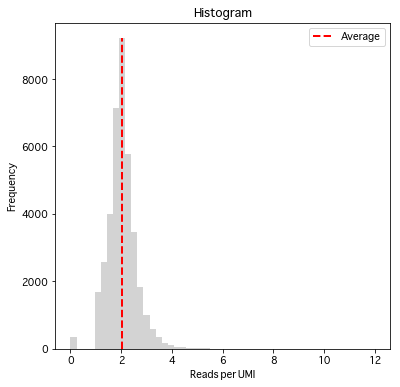

In [44]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

n, bins, _ = ax.hist(np.ravel(df_reads_per_umi.values), bins=50, color="lightgray")
ax.vlines(x=reads_per_umi, ymin=0, ymax=np.max(n), color="red", linestyle="--", lw=2, label="Average")

ax.set_xlabel("Reads per UMI", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_title("Histogram", fontweight="bold")
ax.legend()

plt.show()

## Doublets

In [45]:
df_umi_class = pd.merge(
    df_umis, df_class,
    left_index=True, right_index=True,
    how="inner"
)

In [46]:
df_umi_class

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped,hashID
ATCACTTAGTGAACAT,345,10,16,4,26,A0301
CTCCAACGTGGTCCCA,12,11,17,382,6,A0304
ACAGGGACAGTCGTTA,9,7,20,260,9,A0304
AGCGTCGTCCCATTTA,96,5,6,1,8,A0301
ATGGAGGGTACTCCGG,301,12,23,5,18,A0301
TATCTTGGTATGAAGT,6,2,0,68,0,A0304
TCATCATAGCCGATCC,10,335,30,11,17,A0302
CACGGGTCATGTTCGA,24,34,14,425,9,A0304
CCCATTGGTCAGCTTA,13,9,25,263,6,A0304
TGCTTGCGTGCTAGCC,7,8,16,412,14,A0304


In [47]:
df_umi_class[ df_umi_class.hashID == "Doublet" ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped,hashID
CTGAGGCCAAGTCGTT,14,396,15,320,31,Doublet
AATTCCTTCGCCACTT,9,5,276,611,21,Doublet
TATCTTGGTAGCTGAG,398,8,411,9,39,Doublet
CACCAAAGTTCAGGTT,11,9,429,250,27,Doublet
CGACAGCAGGTTGAGC,7,11,273,283,13,Doublet
GAAGTAAAGTTGCATC,310,20,15,101,29,Doublet
AATGAAGTCGTAGTCA,12,7,563,308,21,Doublet
CATCGTCGTAGTATAG,1204,56,1633,438,120,Doublet
CCCTAACCAGCAGTGA,56,10,36,4,1,Doublet
AGGTCATAGTTGCATC,0,0,0,0,0,Doublet
